 # <font color='blue'> Trabalho de Algoritmos </font> 

Importação das biliotecas e funções a serem utilizadas.

In [37]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew, boxcox
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, plot_confusion_matrix, auc

Leitura dos conjuntos de dados de treinamento e de teste.

In [32]:
train_data=pd.read_csv('aug_train.csv')
test_data=pd.read_csv('aug_test.csv')
train_data.head()
test_data.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Verificação de informações das váriaveis.

In [35]:
print("Train Data INFO \n")
train_data.info() 

Train Data INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64

Cruzamento de variáveis com a varíavel "target".

In [4]:
gen_targ=pd.crosstab(train_data.gender, train_data.target,margins=True)
rev_exp_targ=pd.crosstab(train_data.relevent_experience, train_data.target,margins=True)
edu_lvl_targ=pd.crosstab(train_data.education_level, train_data.target,margins=True)
las_job_targ=pd.crosstab(train_data.last_new_job, train_data.target,margins=True)

Visualização do cruzamento de informações feitas anteriormente.

<AxesSubplot:xlabel='last_new_job', ylabel='value'>

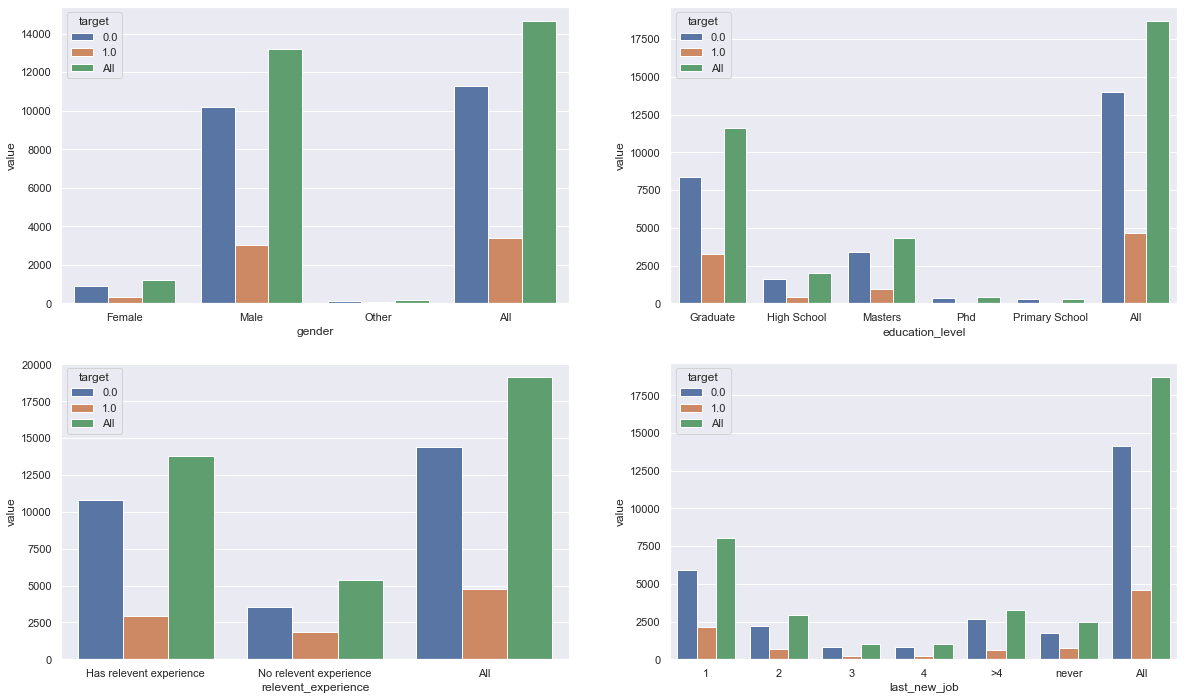

In [23]:

stacked1 = gen_targ.stack().reset_index().rename(columns={0:'value'})
stacked2 = rev_exp_targ.stack().reset_index().rename(columns={0:'value'})
stacked3 = edu_lvl_targ.stack().reset_index().rename(columns={0:'value'})
stacked4 = las_job_targ.stack().reset_index().rename(columns={0:'value'})


fig, axs = plt.subplots(nrows=2,ncols=2)
sns.set(rc={'figure.figsize':(20,12)})
sns.barplot(x=stacked1.gender, y=stacked1.value,hue=stacked1.target,ax=axs[0,0])
sns.barplot(x=stacked2.relevent_experience, y=stacked2.value, hue=stacked2.target,ax=axs[1,0])
sns.barplot(x=stacked3.education_level, y=stacked3.value, hue=stacked3.target,ax=axs[0,1])
sns.barplot(x=stacked4.last_new_job, y=stacked4.value, hue=stacked4.target,ax=axs[1,1])

In [6]:
train_data.training_hours.describe()

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

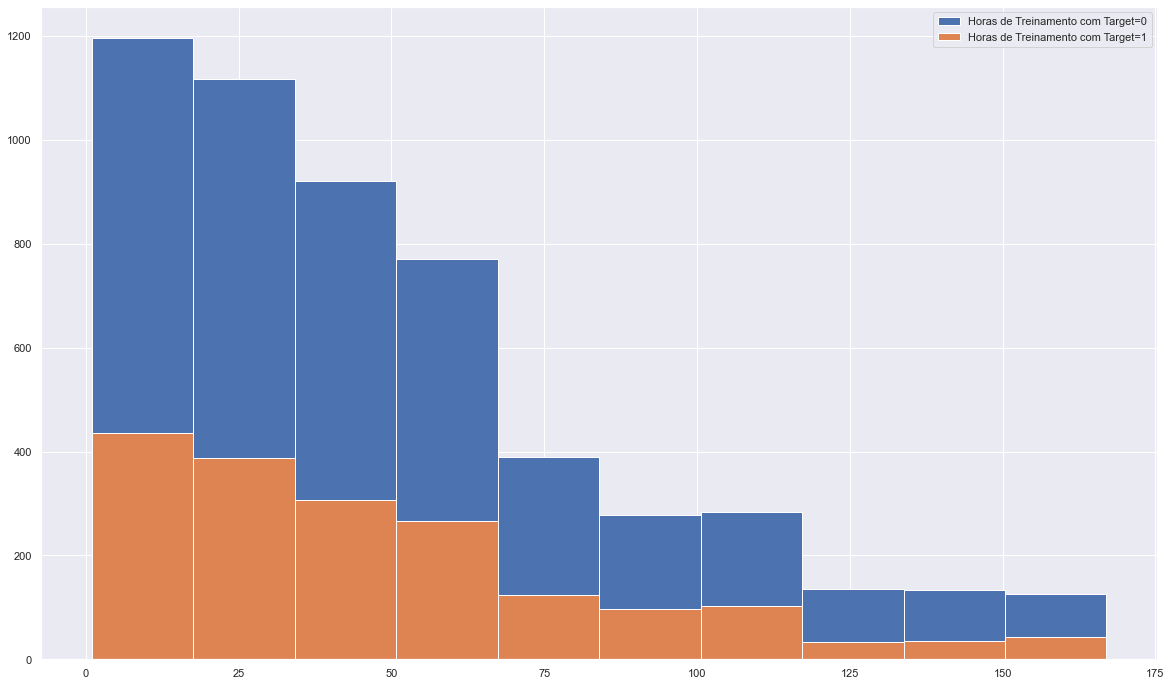

In [7]:
from matplotlib import pyplot

pyplot.hist(train_data[(train_data.training_hours) & (train_data.target==0)].training_hours,label='Horas de Treinamento com Target=0')
pyplot.hist(train_data[(train_data.training_hours) & (train_data.target==1)].training_hours,label='Horas de Treinamento com Target=1')
pyplot.legend(loc='upper right')
pyplot.show()

Encontrando valores faltantes

In [8]:
train_data = pd.concat([train_data,test_data],axis = 0).reset_index(drop = True)

In [9]:
print("\t Quantos valores nulos existem \n \n ",train_data.isnull().sum())

	 Quantos valores nulos existem 
 
  enrollee_id                  0
city                         0
city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline          3125
experience                  70
company_size              6560
company_type              6774
last_new_job               463
training_hours               0
target                    2129
dtype: int64


In [10]:
print("\t Percentual de Valores nulos \n \n ",
      abs(1-(train_data.isnull().sum()+train_data.notnull().sum())/train_data.notnull().sum())*100)

	 Percentual de Valores nulos 
 
  enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    30.827853
relevent_experience        0.000000
enrolled_university        1.998083
education_level            2.464501
major_discipline          17.206255
experience                 0.329924
company_size              44.544035
company_type              46.675394
last_new_job               2.223396
training_hours             0.000000
target                    11.112851
dtype: float64


Retiramos do dataset as linhas das colunas que possuem poucos dados faltantes.

In [24]:
train_data.dropna(subset=["experience"], inplace=True)
train_data.dropna(subset=["enrolled_university"], inplace=True)
train_data.dropna(subset=["last_new_job"], inplace=True)
train_data.dropna(subset=["education_level"], inplace=True)

In [38]:
#major_discipline
print("most repetitive --> ",train_data["major_discipline"].value_counts().index[0])
train_data["major_discipline"].fillna( method ='ffill', limit = 3, inplace = True)

train_data.dropna(subset=["major_discipline"], inplace=True)
print("NULL major_discipline --> ",train_data["major_discipline"].isnull().sum())

#company_size
train_data["company_size"].fillna( method ='ffill', limit = 2, inplace = True)

train_data.dropna(subset=["company_size"], inplace=True)
print("NULL company_size --> ",train_data["company_size"].isnull().sum())

#company_type
train_data["company_type"].fillna( method ='ffill', limit = 2, inplace = True)

train_data.dropna(subset=["company_type"], inplace=True)
print("NULL company_type --> ",train_data["company_type"].isnull().sum())

#gender
train_data["gender"].fillna( method ='ffill', limit = 2, inplace = True)

train_data.dropna(subset=["gender"], inplace=True)
print("NULL gender --> ",train_data["gender"].isnull().sum())
train_data.head()

most repetitive -->  STEM
NULL major_discipline -->  0
NULL company_size -->  0
NULL company_type -->  0
NULL gender -->  0


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,NaN,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,Male,Has relevent experience,Part time course,Graduate,STEM,11,50-99,Funded Startup,1,24,1.0


In [14]:
#gender
# male = 0 , female = 1, other = 2
train_data["gender"] = [ 0 if gender == "Male"
                        else 1 if gender == "Female"
                        else 2 for gender in train_data["gender"]]

# Has relevent experience = 0 , No relevent experience = 1
train_data["relevent_experience"] = [ 0 if i == "Has relevent experience"
                                    else 1 for i in train_data["relevent_experience"]]

#enrolled_university 
# no_enrollment = 0 , Full time course = 1, Part time course = 2

train_data["enrolled_university"] = [ 0 if i == "no_enrollment"
                                    else 1 if i == "Full time course"
                                    else 2 for i in train_data["enrolled_university"]]

#education_level
# Graduate = 0 , Masters = 1, High School = 2, Phd = 3, Primary School = 4 

train_data["education_level"] = [ 0 if i == "Graduate"
                                    else 1 if i == "Masters"
                                    else 2 if i == "High School"
                                    else 3 if i == "Phd" 
                                    else 4 for i in train_data["education_level"]]

#major_discipline 
# STEM  = 0 , Humanities = 1, Business Degree = 2, Arts = 3, No Major = 4, Other = 5 

train_data["major_discipline"] = [ 0 if i == "STEM"
                                    else 1 if i == "Humanities"
                                    else 2 if i == "Business Degree"
                                    else 3 if i == "Arts" 
                                    else 4 if i == "No Major" 
                                    else 5 for i in train_data["major_discipline"]]
#experience
train_data["experience"] = [ 0 if i == "2" or i == "1" or i == "4" or i == "<1" or i == "3"
                                    else 1 if i == "5>" or i == "11" or i == "7" or i == "10" or i == "6" or i == "9" or i == "8" or i == "20"
                                    else 2 for i in train_data["experience"]]
#company_size
train_data["company_size"] = [ 0 if i == "10/49"
                                    else 1 for i in train_data["company_size"]]
#company_type
# pvt ltd = 0, Funded Startup  = 1 , Public Sector  = 2, Early Stage Startup = 3, NGO = 4 , else 5 

train_data["company_type"] = [ 0 if i == "Pvt Ltd"
                               else 1 if i == "Funded Startup"
                               else 2 if i == "Public Sector"
                               else 3 if i == "Early Stage Startup"
                               else 4 if i == "NGO" 
                               else 5 for i in train_data["company_type"]]

train_data["company_type"] = [ 0 if i == 3 or i == 4
                               else 1 if i == 2
                               else 2 for i in train_data["company_type"]]

#last_new_job
train_data["last_new_job"] = [ 0 if i == "1"
                               else 1 if i == "2"
                               else 2 if i == "3"
                               else 3 if i == "4"
                               else 4 if i == "never" 
                               else 5 for i in train_data["last_new_job"]]

train_data["last_new_job"] = [ 0 if i == 4
                               else 1 if i == 5
                               else 2 for i in train_data["last_new_job"]]
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,city_40,0.776,0,1,0,0,0,2,1,2,1,47,0.0
2,11561,city_21,0.624,0,1,1,0,0,2,1,2,0,83,0.0
4,666,city_162,0.767,0,0,0,1,0,2,1,2,2,8,0.0
5,21651,city_176,0.764,0,0,2,0,0,1,1,2,2,24,1.0
6,28806,city_160,0.920,0,0,0,2,0,2,1,2,2,24,0.0


In [15]:
#city
le = LabelEncoder()
train_data["city"] = le.fit_transform(train_data["city"])
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,29725,77,0.776,0,1,0,0,0,2,1,2,1,47,0.0
2,11561,64,0.624,0,1,1,0,0,2,1,2,0,83,0.0
4,666,50,0.767,0,0,0,1,0,2,1,2,2,8,0.0
5,21651,57,0.764,0,0,2,0,0,1,1,2,2,24,1.0
6,28806,49,0.920,0,0,0,2,0,2,1,2,2,24,0.0


In [20]:
train_data = train_data.reset_index(drop=True)
test = train_data[17248:]
test.drop(labels = ["target","enrollee_id"],axis = 1, inplace = True)
train = train_data[:17248]
train.drop(labels = ["enrollee_id"],axis = 1, inplace = True)

C:\Users\luciano\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
X = train.drop(labels = "target", axis = 1)
y = train["target"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("test",len(test))

X_train 13798
X_test 3450
y_train 13798
y_test 3450
test 1930


In [19]:
# model accuracy
result = []

random_forest_model = RandomForestClassifier(max_depth=7, random_state= 59)
random_forest_model.fit(X_train, y_train)
y_pred_random_forest = random_forest_model.predict(X_test)
cm_random_forest = confusion_matrix(y_pred_random_forest, y_test)
acc_random_forest = accuracy_score(y_test, y_pred_random_forest)
result.append(acc_random_forest)
print("RESULT")
print("Random Forest Model Acc : ",acc_random_forest)

RESULT
Random Forest Model Acc :  0.8049275362318841
